# fashion_mnist_example on ArcFace
fashion mnist dataset has 10 classes in 4 varieties:  
- Tops: T-shirt/top, Pullover, Dress, Coat, Shirt
- Bottoms: Trouser
- Shoes: Sandal, Sneaker, Ankle boot
- Bags: Bag

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, log_loss
from sklearn.model_selection import train_test_split
import tensorflow as tf

from models.cnn import vgg8_arcface
from src.utils import plot_confusion_matrix, plot_learning_history
from src.keras_callback import get_callback
from src.keras_utils import get_features_arcface, plot_model, predict_arcface

tf.random.set_seed(1)
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",  "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

In [2]:
# load fashion mnist dataset
fashion_mnist = tf.keras.datasets.fashion_mnist
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

# shape of dataset
print(f"{X_train.shape=}\n {y_train.shape=}\n {X_test.shape=}\n {y_test.shape=}")

X_train.shape=(60000, 28, 28)
 y_train.shape=(60000,)
 X_test.shape=(10000, 28, 28)
 y_test.shape=(10000,)


In [3]:
# Normalize image data
X_train = X_train / 255.0
X_test = X_test / 255.0

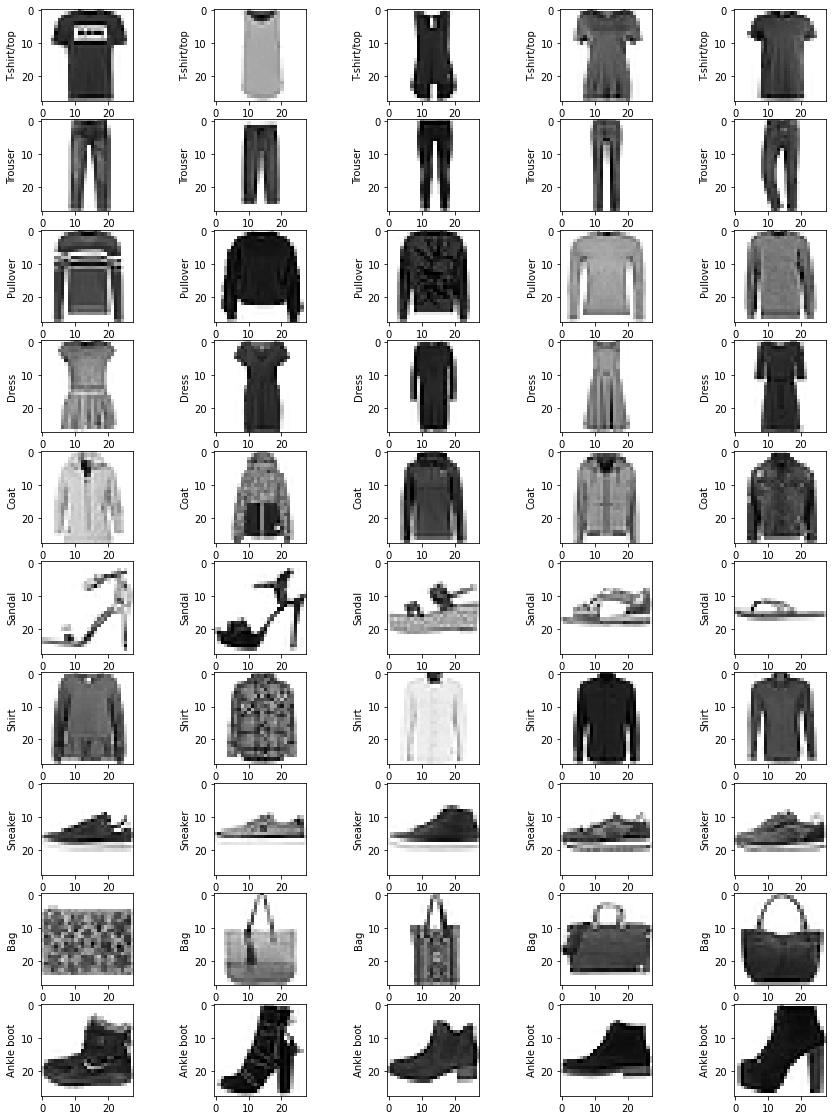

In [4]:
# Plot some images of each class
f, ax = plt.subplots(10, 5, figsize=(15, 20))
for cls in range(10):
    imgs = X_train[np.where(y_train == cls)][:5]  # Pick up 5 images
    for j in range(5):
        ax[cls, j].imshow(imgs[j], cmap=plt.cm.binary)
        ax[cls, j].set_ylabel(class_names[cls])

plt.show()

In [4]:
# prepare train / validation / test data
X_train = X_train.reshape(*X_train.shape, 1)
y_train = tf.keras.utils.to_categorical(y_train, 10)
X_test= X_test.reshape(*X_test.shape, 1)
y_test = tf.keras.utils.to_categorical(y_test, 10)

X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=71, shuffle=True, stratify=y_train)

In [5]:
model = vgg8_arcface()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
callbacks = get_callback(patience=5, path_chpt="models/vgg8_arcface_fashion_mnist.h5")
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 28, 28, 16)   160         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 28, 28, 16)   64          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 28, 28, 16)   0           batch_normalization[0][0]        
_______________________________________________________________________________________

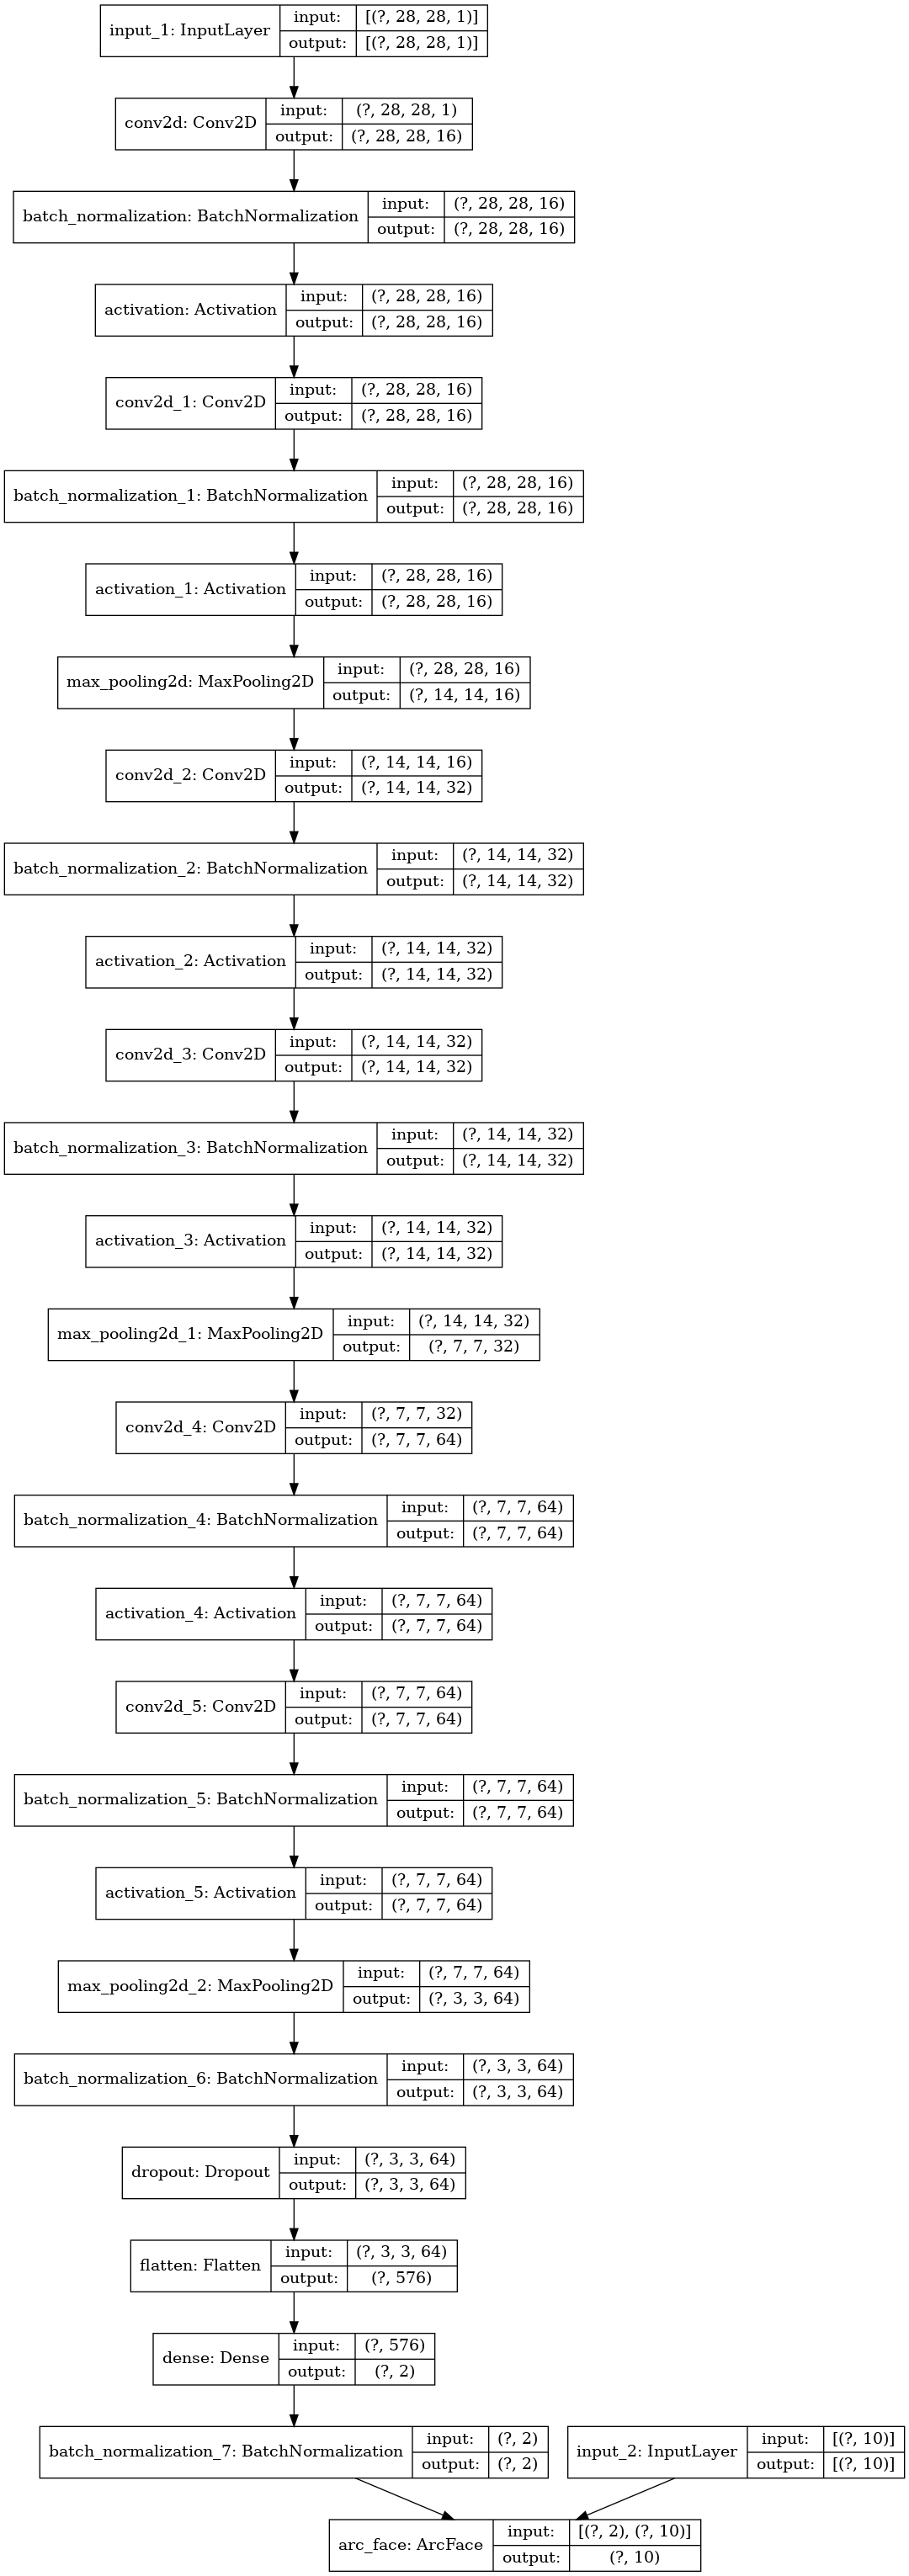

In [6]:
plot_model(model, path="models/vgg8_arcface.png")

In [7]:
fit = model.fit(
    [X_tr, y_tr], y_tr,
    epochs=1000,
    validation_data=([X_val, y_val], y_val),
    callbacks=callbacks,
    verbose=1
    )

Epoch 1/1000
1313/1313 [==============================] - 14s 10ms/step - loss: 8.5628 - accuracy: 0.1912 - val_loss: 5.0279 - val_accuracy: 0.2462
Epoch 2/1000
1313/1313 [==============================] - 13s 10ms/step - loss: 5.8614 - accuracy: 0.2152 - val_loss: 5.4439 - val_accuracy: 0.2577
Epoch 3/1000
1313/1313 [==============================] - 13s 10ms/step - loss: 5.4953 - accuracy: 0.2274 - val_loss: 4.4934 - val_accuracy: 0.2740
Epoch 4/1000
1313/1313 [==============================] - 13s 10ms/step - loss: 5.1539 - accuracy: 0.2362 - val_loss: 4.3624 - val_accuracy: 0.2787
Epoch 5/1000
1313/1313 [==============================] - 12s 9ms/step - loss: 5.0158 - accuracy: 0.2422 - val_loss: 4.2420 - val_accuracy: 0.2781
Epoch 6/1000
1313/1313 [==============================] - 13s 10ms/step - loss: 4.8417 - accuracy: 0.2461 - val_loss: 4.0769 - val_accuracy: 0.2748
Epoch 7/1000
1313/1313 [==============================] - 13s 10ms/step - loss: 4.5373 - accuracy: 0.2989 - val_l

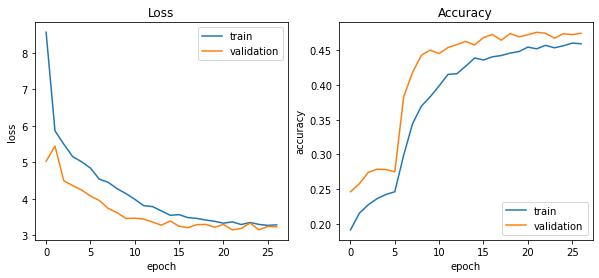

In [8]:
plot_learning_history(fit)

In [9]:
# load best weight
# model = tf.keras.models.load_model("models/vgg8_arcface_fashion_mnist.h5")
model.load_weights("models/vgg8_arcface_fashion_mnist.h5")

# evaluate model
pred_prob_tr, pred_tr = predict_arcface(model, X_tr)
pred_prob_val, pred_val = predict_arcface(model, X_val)
pred_prob_test, pred_test = predict_arcface(model, X_test)

print(f"train loss={log_loss(y_tr, pred_prob_tr):.4f}\t accuracy={accuracy_score(y_tr.argmax(axis=1), pred_tr):.4f}")
print(f"validation loss={log_loss(y_val, pred_prob_val):.4f}\t accuracy={accuracy_score(y_val.argmax(axis=1), pred_val):.4f}")
print(f"test loss={log_loss(y_test, pred_prob_test):.4f}\t accuracy={accuracy_score(y_test.argmax(axis=1), pred_test):.4f}")

train loss=1.9178	 accuracy=0.5835
validation loss=1.9203	 accuracy=0.5762
test loss=1.9206	 accuracy=0.5755


### 混合行列
- T-shirt/top, Pullover, Dress, Coat, Shirtが全てShirtへ誤分類されている (そもそもの識別性能の劣化)
- SneakerからAnkle bootへの誤分類が多い (似たクラス)
- Trouser(ズボン)、Sandal, Bag、Ankle bootは他クラスへの誤分類が少ない

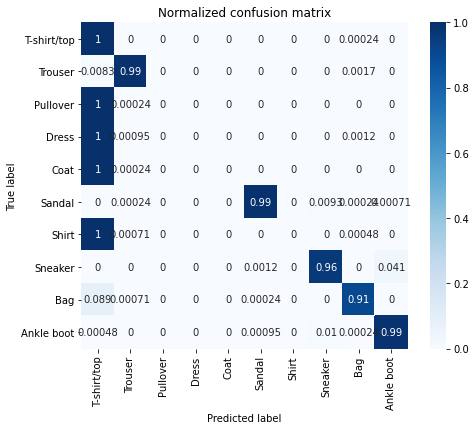

In [10]:
# train confision matrix
plot_confusion_matrix(y_tr.argmax(axis=1), pred_tr, labels=class_names, figsize=(8, 6))

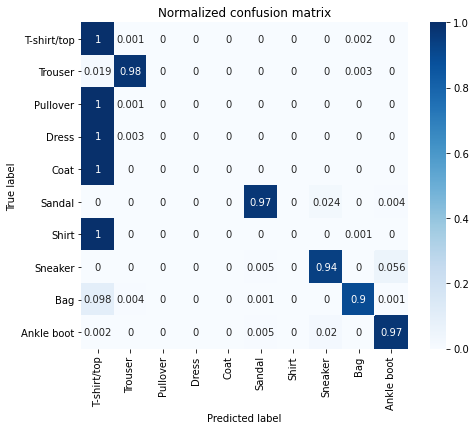

In [11]:
# test confision matrix
plot_confusion_matrix(y_test.argmax(axis=1), pred_test, labels=class_names, figsize=(8, 6))

### Plot embedding
- inter-class varianceが確かに大きくなっている
- そもそもの識別性能が著しく落ちているため、似たクラスが被っている (ArcFaceの特性かは不明)

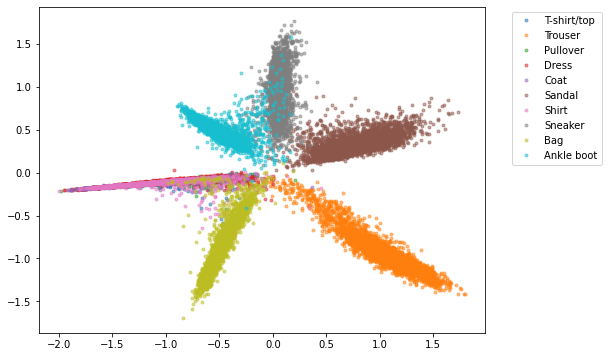

In [12]:
# plot fully-connected output - train
feat_train = get_features_arcface(model=model, X=X_tr)
fig = plt.figure(figsize=(8, 6))
for cls in range(10):
    plt.plot(feat_train[y_tr.argmax(axis=-1)==cls, 0], feat_train[y_tr.argmax(axis=-1)==cls, 1], '.', alpha=0.5, label=class_names[cls])

plt.legend(bbox_to_anchor=(1.05, 1))
plt.show()

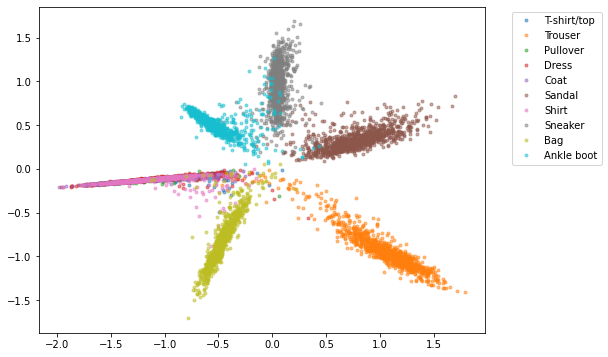

In [13]:
# plot fully-connected output - test
feat_test = get_features_arcface(model=model, X=X_test)
fig = plt.figure(figsize=(8, 6))
for cls in range(10):
    plt.plot(feat_test[y_test.argmax(axis=-1)==cls, 0], feat_test[y_test.argmax(axis=-1)==cls, 1], '.', alpha=0.5, label=class_names[cls])

plt.legend(bbox_to_anchor=(1.05, 1))
plt.show()

### Plot weights
- 出力(XW)の方向に一致

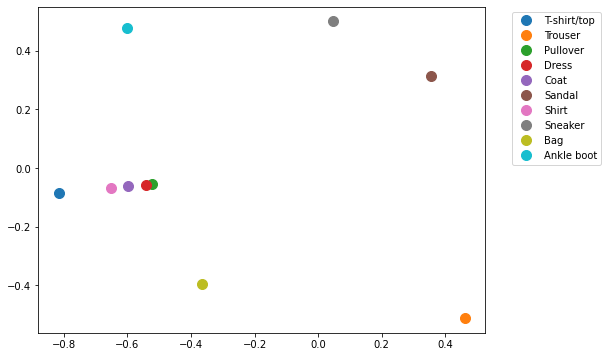

In [14]:
# plot fully-connected weight
wgt = model.layers[-1].get_weights()[0]
fig = plt.figure(figsize=(8, 6))
for cls in range(10):
    plt.plot(wgt[0, cls], wgt[1, cls], '.', markersize=20, label=class_names[cls])

plt.legend(bbox_to_anchor=(1.05, 1))
plt.show()